**Import Libraries**

In [20]:
import json
import numpy as np
import random
import nltk
from nltk.stem import WordNetLemmatizer
import pickle
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.python.framework import ops
from keras.models import load_model

# Ignore warning
warnings.filterwarnings('ignore')

# Download required NLTK packages
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Prepare Data**

In [21]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize variables
words = []
classes = []
documents = []
ignore_words = ['?', '!']

with open('intents.json') as file:
    intents = json.load(file)

# Loop through each intent in the JSON file
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # Tokenize each sentence
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# Lemmatize, lowercase, dan remove duplicates
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# Sort the classes
classes = sorted(list(set(classes)))

# Save data to pickle files
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

print(f"{len(documents)} documents\n{documents}\n")
print(f"{len(classes)} classes\n{classes}\n")
print(f"{len(words)} unique lemmatized words\n{words}\n")


8874 documents
[(['Hi'], 'greeting'), (['How', 'are', 'you', '?'], 'greeting'), (['Is', 'anyone', 'there', '?'], 'greeting'), (['Hello'], 'greeting'), (['Good', 'day'], 'greeting'), (['What', "'s", 'up'], 'greeting'), (['how', 'are', 'ya'], 'greeting'), (['heyy'], 'greeting'), (['whatsup'], 'greeting'), (['?', '?', '?', '?', '?', '?', '?', '?'], 'greeting'), (['cya'], 'goodbye'), (['see', 'you'], 'goodbye'), (['bye', 'bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['Goodbye'], 'goodbye'), (['I', 'am', 'Leaving'], 'goodbye'), (['Bye'], 'goodbye'), (['Have', 'a', 'Good', 'day'], 'goodbye'), (['talk', 'to', 'you', 'later'], 'goodbye'), (['ttyl'], 'goodbye'), (['i', 'got', 'to', 'go'], 'goodbye'), (['gtg'], 'goodbye'), (['What', 'are', 'the', 'cultural', 'norms', 'in', 'Aceh', '?'], 'Culture Norms Aceh'), (['How', 'should', 'I', 'behave', 'when', 'visiting', 'Aceh', '?'], 'Culture Norms Aceh'), (['What', 'are', 'the', 'customs', 'in', 'Aceh', '?'], 'Culture Norms Aceh'), (['What

**Preprocess Data**

In [22]:
from sklearn.model_selection import train_test_split

# Create training data
training = []
output_empty = [0] * len(classes)

# Create bag of words for each sentence
for doc in documents:
    bag = []
    pattern_words = doc[0]
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]

    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])

# Shuffle the training data and convert to numpy array
random.shuffle(training)
training = np.array(training, dtype=object)

# Separate data into X (patterns) and y (intents)
X = list(training[:, 0])
y = list(training[:, 1])

# Split the data into training set and validation set
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)


Build the Model

In [23]:
# Reset the graph if one already exists
ops.reset_default_graph()

model = Sequential([
    tf.keras.layers.Dense(512, input_shape=(len(train_x[0]),), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(len(train_y[0]), activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 512)                 │         476,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1529)                │         197,241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,209 (3.21 MB)

 Trainable params: 839,417 (3.20 MB)

 Non-trainable params: 1,792 (7.00 KB)

**Train model**

In [24]:
# Train the model with callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train the model
hist = model.fit(
    np.array(train_x),
    np.array(train_y),
    epochs=100,
    batch_size=8,
    validation_data=(np.array(val_x), np.array(val_y)),
    callbacks=callbacks
)



Epoch 1/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 7.9559e-04 - loss: 7.4418 - val_accuracy: 5.6338e-04 - val_loss: 7.3203 - learning_rate: 1.0000e-04
Epoch 2/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.0020 - loss: 7.3485 - val_accuracy: 0.0045 - val_loss: 7.2571 - learning_rate: 1.0000e-04
Epoch 3/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.0020 - loss: 7.2438 - val_accuracy: 0.0090 - val_loss: 7.1874 - learning_rate: 1.0000e-04
Epoch 4/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.0063 - loss: 7.1393 - val_accuracy: 0.0220 - val_loss: 7.0951 - learning_rate: 1.0000e-04
Epoch 5/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.0127 - loss: 7.0617 - val_accuracy: 0.0332 - val_loss: 6.9889 - learning_rate: 1.0000e-04
Epoch 6/100
888/888 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.0236 - loss: 6.9422 - val_accuracy: 0.0428 - val_loss: 6.8511 - learning_rate: 1.0000e-04
Epoch 7/100
888/888 ━━━━━━━━━━━━━━━━━━

In [25]:
# Save the model
model.save('chatbot_model.h5')

Plot model

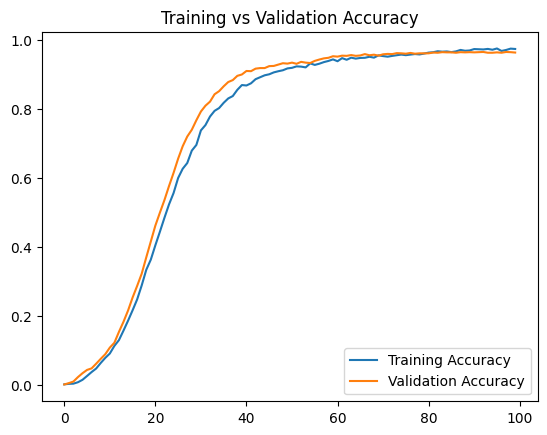

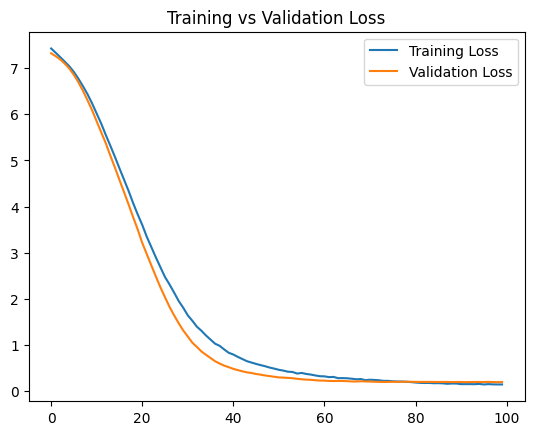

In [26]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


**Prediction and Response**

In [27]:
# Preprocessing Input
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

def bow(sentence, words, show_details=True):
    sentence_words = clean_up_sentence(sentence)
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                bag[i] = 1
                if show_details:
                    print(f"Found in bag: {w}")
    return np.array(bag)

# Chatbot Prediction and Response Functions
def predict_class(sentence, model):
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def get_response(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if i['tag'] == tag:
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(text):
    ints = predict_class(text, model)
    res = get_response(ints, intents)
    return res

**User Interaction**

In [28]:
print("Chatbot is ready! Type 'quit' to exit.")
while True:
    message = input("You: ")
    if message.lower() == "quit":
        break
    response = chatbot_response(message)
    print("Chatbot:", response)


Chatbot is ready! Type 'quit' to exit.
You: hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Chatbot: Good to see you again!
You: tell me about culture norm in aceh
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Chatbot: When visiting Aceh, it's important to wear modest clothing. Women should wear a hijab, and men should avoid wearing shorts in public.
You: what should i avoid during nyepi in bali?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Chatbot: Be respectful by not touching religious offerings or idols, avoid stepping on temple grounds without the proper dress code, and refrain from loud behavior during ceremonies.
You: bye
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Chatbot: Come back soon
You: quit
